First we need to import the useful libraries and load the data that we have previously prepared.

In [4]:
import os
import h5py
import csv
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
#Load data and labels
print('\nLoading data...\n')

project_dir='path/to/data'
file_name_h5 = os.path.join(project_dir, 'farmboys_data.h5')
h5f = h5py.File(file_name_h5,'r')
X = h5f['dataset'][:]
h5f.close()

y_list=[]
file_name_txt = os.path.join(project_dir, 'farmboys_labels.txt')
file = open(file_name_txt,"r") 
for line in file:
    y_list.append(line.strip())
y=np.asarray(y_list).astype(np.float64)

print('Samples loaded successfully:',X.shape)
print('Labels loaded successfully:',y.shape)


Loading data...

Samples loaded successfully: (200, 18)
Labels loaded successfully: (200,)


Now we create and train the Random Forest model, using 10-fold validation.

In [6]:
# Create model
model=Sequential()
model.add(Dense(48,activation='relu'))
model.add(Dense(48,activation='relu'))
model.add(Dense(24,activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
print("\nModel created successfully!\n")


Model created successfully!



In [7]:
#Training the model
kf= KFold(n_splits=10,shuffle=True,random_state=42)
stdsc=StandardScaler()
num_epochs=500
callbacks_list=[EarlyStopping(monitor='val_loss', patience=100)]

y_train=[]
y_test=[]
train_pred=[]
test_pred=[]
mse_train_results=[]
mse_test_results=[]
me_train_results=[]
me_test_results=[]
r2_train_results=[]
r2_test_results=[]
all_history=[]

for train, test in kf.split(X,y): 
    y_train.append(y[train])
    y_test.append(y[test])
    
    X_train=stdsc.fit_transform(X[train])
    X_test=stdsc.transform(X[test])
    
    history=model.fit(X_train,y[train],epochs=num_epochs,batch_size=4,verbose=0,
                      validation_data=(X_test,y[test]),callbacks=callbacks_list)
    all_history.append(history)
    
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    train_pred.append(y_train_pred)
    test_pred.append(y_test_pred)
    
    mse_train=mean_squared_error(y[train],y_train_pred)
    mse_test=mean_squared_error(y[test],y_test_pred)
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)
    
    me_train=mean_absolute_error(y[train],y_train_pred)
    me_test=mean_absolute_error(y[test],y_test_pred)
    me_train_results.append(me_train)
    me_test_results.append(me_test)
    
    r2_train=r2_score(y[train],y_train_pred)
    r2_test=r2_score(y[test],y_test_pred)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)

print("\nTraining finished correctly!\n")


Training finished correctly!



Then we evaluate our predictions, using MAE (mean absolute error), MSE (mean squared error), and R2 (coefficient of determination).

In [8]:
print('Results:')
for i in range(len(mse_train_results)):
    print('\nK-fold: ',i+1)
    print('MSE train: {0:.3f}   MSE validation: {1:.3f}'.format(mse_train_results[i],
          mse_test_results[i]))
    print('MAE train: {0:.3f}   MAE validation: {1:.3f}'.format(me_train_results[i],
          me_test_results[i]))
    print('r^2 train: {0:.3f}   r^2 validation: {1:.3f}'.format(r2_train_results[i],
          r2_test_results[i]))

print('\nAverage values:')    
print('MSE train: {0:.3f}   MSE validation: {1:.3f}'.format(np.mean(mse_train_results),
      np.mean(mse_test_results)))
print('MAE train: {0:.3f}   MAE validation: {1:.3f}'.format(np.mean(me_train_results),
      np.mean(me_test_results)))
print('r^2 train: {0:.3f}   r^2 validation: {1:.3f}'.format(np.mean(r2_train_results),
      np.mean(r2_test_results)))

Results:

K-fold:  1
MSE train: 0.048   MSE validation: 0.426
MAE train: 0.118   MAE validation: 0.420
r^2 train: 0.900   r^2 validation: 0.586

K-fold:  2
MSE train: 0.044   MSE validation: 0.100
MAE train: 0.107   MAE validation: 0.218
r^2 train: 0.915   r^2 validation: 0.842

K-fold:  3
MSE train: 0.042   MSE validation: 0.111
MAE train: 0.110   MAE validation: 0.176
r^2 train: 0.926   r^2 validation: 0.515

K-fold:  4
MSE train: 0.108   MSE validation: 0.056
MAE train: 0.170   MAE validation: 0.149
r^2 train: 0.809   r^2 validation: 0.753

K-fold:  5
MSE train: 0.049   MSE validation: 0.041
MAE train: 0.119   MAE validation: 0.130
r^2 train: 0.908   r^2 validation: 0.917

K-fold:  6
MSE train: 0.043   MSE validation: 0.090
MAE train: 0.112   MAE validation: 0.164
r^2 train: 0.925   r^2 validation: -0.468

K-fold:  7
MSE train: 0.049   MSE validation: 0.024
MAE train: 0.118   MAE validation: 0.101
r^2 train: 0.911   r^2 validation: 0.930

K-fold:  8
MSE train: 0.043   MSE validation

We can see that the results are fairly good for the training set, and not so bad for validation. However, it is also important to have some visualization of the results.

Ideally, predictions should follow the red line in the middle. The residuals plot helps us to see if there are any patterns in the predictions.

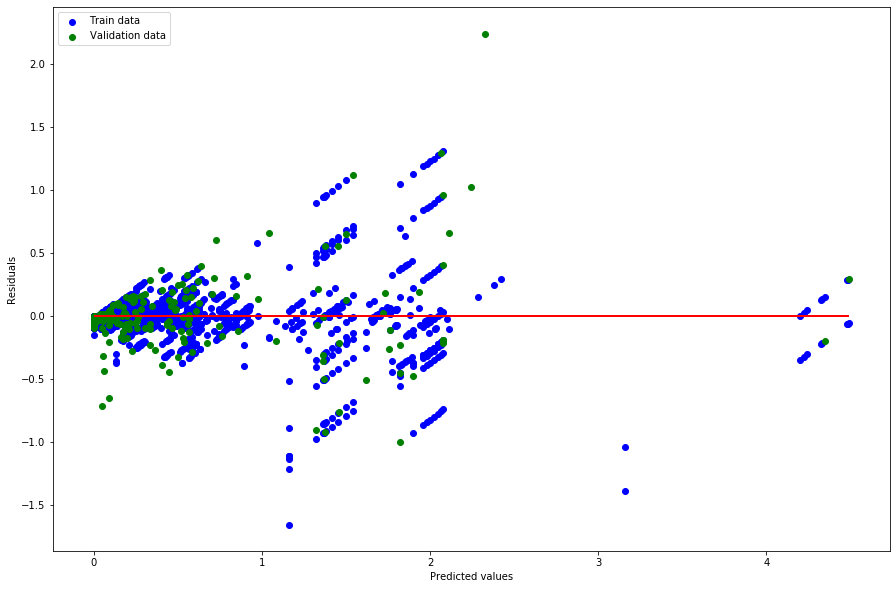

In [9]:
#Residuals plot
a=np.concatenate(train_pred)[:,0]
b=np.concatenate(y_train)
diff_train=a-b

c=np.concatenate(test_pred)[:,0]
d=np.concatenate(y_test)
diff_test=c-d

title='Residual_plot_NN'
plt.figure(title,figsize=(15,10))
plt.scatter(a,diff_train,c='blue',label='Train data')
plt.scatter(c,diff_test,c='green',label='Validation data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=min(a),xmax=max(a),lw=2,color='red')
plt.show()

We also need to see how well the predictions fit the ground truth.

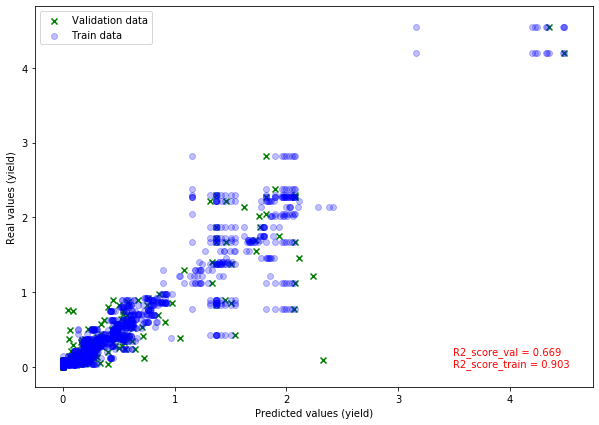

In [10]:
#Plot regression
title='Real_and_predicted_values_NN'
plt.figure(title,figsize=(10,7))
plt.scatter(c,d,c='green',marker='x',label='Validation data')
plt.scatter(a,b,c='blue',marker='o',label='Train data', alpha=0.25)
plt.xlabel('Predicted values (yield)')
plt.ylabel('Real values (yield)')
plt.legend(loc='upper left')
plt.text(max(c)-1,min(d),
         'R2_score_val = '+str(round(np.mean(r2_test_results),3))+
         '\nR2_score_train = '+str(round(np.mean(r2_train_results),3)),
         color='red')
plt.show()

Also, in the case of the Neural Network, it is informative to plot the training curves. These curves have been averaged for the 10-fold process, they have been smoothed, and also the first values have been omited for better visualization.

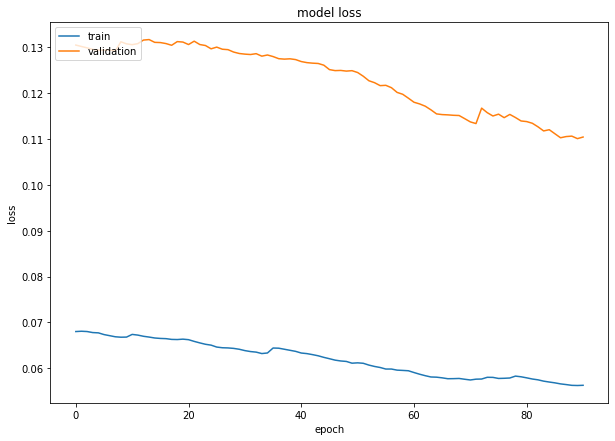

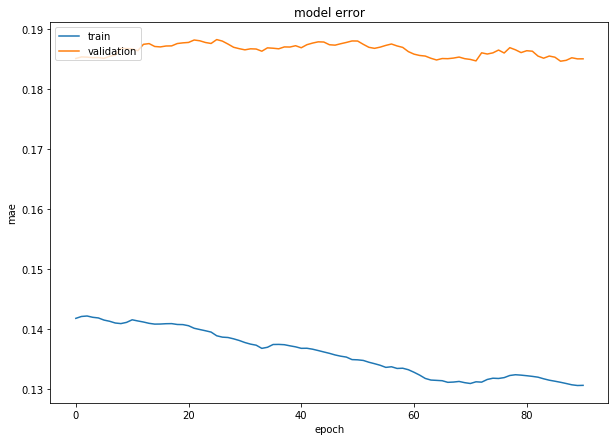

In [11]:
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

#Plot training scores
all_val_loss=[]
all_val_mean_absolute_error=[]
all_loss=[]
all_mean_absolute_error=[]
for hst in all_history:
    val_loss=hst.history['val_loss']
    all_val_loss.append(val_loss)
    
    val_mean_absolute_error=hst.history['val_mean_absolute_error']
    all_val_mean_absolute_error.append(val_mean_absolute_error)
    
    loss=hst.history['loss']
    all_loss.append(loss)
    
    mean_absolute_error=hst.history['mean_absolute_error']
    all_mean_absolute_error.append(mean_absolute_error)

len_list=[]
for length in range(len(all_loss)):
    len_list.append(len(all_loss[length]))
    
num_epochs=min(len_list)

average_val_loss=[np.mean(
        [x[i] for x in all_val_loss]) for i in range(num_epochs)]
average_val_mean_absolute_error=[np.mean(
        [x[i] for x in all_val_mean_absolute_error]) for i in range(num_epochs)]
average_loss=[np.mean(
        [x[i] for x in all_loss]) for i in range(num_epochs)]
average_mean_absolute_error=[np.mean(
        [x[i] for x in all_mean_absolute_error]) for i in range(num_epochs)]

smoothed_average_val_loss=smooth_curve(average_val_loss[10:]) 
smoothed_average_val_mean_absolute_error=smooth_curve(
        average_val_mean_absolute_error[10:])
smoothed_average_loss=smooth_curve(average_loss[10:])
smoothed_average_mean_absolute_error=smooth_curve(
        average_mean_absolute_error[10:])

title='Training_and_validation_loss'
plt.figure(title,figsize=(10,7))
plt.plot(smoothed_average_loss)
plt.plot(smoothed_average_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

title='Training_and_validation_error'
plt.figure(title,figsize=(10,7))
plt.plot(smoothed_average_mean_absolute_error)
plt.plot(smoothed_average_val_mean_absolute_error)
plt.title('model error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Finally, we can save those results and the model, for future analysis and to predict future samples.

In [12]:
#Writing to CSV
file_summary=project_dir+'/results_summary_rf.csv'

with open(file_summary, 'w', newline='') as csvfile:
    results = csv.writer(csvfile, delimiter=',')
    results.writerow(['Average values (metrics):'])
    results.writerow(['MSE train:'])
    results.writerow([np.mean(mse_train_results)])
    results.writerow(['MSE validation:'])
    results.writerow([np.mean(mse_test_results)])
    results.writerow(['MAE train:'])
    results.writerow([np.mean(me_train_results)])
    results.writerow(['MAE validation:'])
    results.writerow([np.mean(me_test_results)])
    results.writerow(['r^2 train:'])
    results.writerow([np.mean(r2_train_results)])
    results.writerow(['r^2 validation:'])
    results.writerow([np.mean(r2_test_results)])

print("\nResults generated correctly!\n")

#Saving model
model_file=os.path.join(project_dir,'model_rf.sav')
pickle.dump(model, open(model_file, 'wb'))
print('Model saved correctly!')

print("\nJob finished! =) \n")


Results generated correctly!

Model saved correctly!

Job finished! =) 

